### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 
    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [7]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [ ]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [10]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')




Train on 1712 samples, validate on 428 samples
Epoch 1/150





1712/1712 [==============================] - 6s 4ms/step - loss: 0.0082 - val_loss: 0.0026

Epoch 00001: val_loss improved from inf to 0.00261, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 2s 961us/step - loss: 0.0022 - val_loss: 0.0020

Epoch 00002: val_loss improved from 0.00261 to 0.00199, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 2s 960us/step - loss: 0.0015 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00199 to 0.00186, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 2s 950us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00186
Epoch 5/150
1712/1712 [==============================] - 2s 966us/step - loss: 0.0012 - val_loss: 0.0018

Epoch 00005: val_loss improved from 0.00186 to 0.00182, saving model to best_weights.h5
Epoch 6/150
1712/1


Epoch 00035: val_loss improved from 0.00079 to 0.00078, saving model to best_weights.h5
Epoch 36/150
1712/1712 [==============================] - 2s 951us/step - loss: 2.3927e-04 - val_loss: 8.1428e-04

Epoch 00036: val_loss did not improve from 0.00078
Epoch 37/150
1712/1712 [==============================] - 2s 952us/step - loss: 2.4056e-04 - val_loss: 7.7486e-04

Epoch 00037: val_loss improved from 0.00078 to 0.00077, saving model to best_weights.h5
Epoch 38/150
1712/1712 [==============================] - 2s 954us/step - loss: 2.3193e-04 - val_loss: 7.5594e-04

Epoch 00038: val_loss improved from 0.00077 to 0.00076, saving model to best_weights.h5
Epoch 39/150
1712/1712 [==============================] - 2s 948us/step - loss: 2.3054e-04 - val_loss: 7.6894e-04

Epoch 00039: val_loss did not improve from 0.00076
Epoch 40/150
1712/1712 [==============================] - 2s 952us/step - loss: 2.3015e-04 - val_loss: 8.0140e-04

Epoch 00040: val_loss did not improve from 0.00076
Epoch 4

1712/1712 [==============================] - 2s 956us/step - loss: 1.3652e-04 - val_loss: 7.5454e-04

Epoch 00083: val_loss did not improve from 0.00072
Epoch 84/150
1712/1712 [==============================] - 2s 954us/step - loss: 1.3685e-04 - val_loss: 7.4837e-04

Epoch 00084: val_loss did not improve from 0.00072
Epoch 85/150
1712/1712 [==============================] - 2s 952us/step - loss: 1.3978e-04 - val_loss: 7.5816e-04

Epoch 00085: val_loss did not improve from 0.00072
Epoch 86/150
1712/1712 [==============================] - 2s 954us/step - loss: 1.3310e-04 - val_loss: 7.6486e-04

Epoch 00086: val_loss did not improve from 0.00072
Epoch 87/150
1712/1712 [==============================] - 2s 963us/step - loss: 1.3356e-04 - val_loss: 7.3961e-04

Epoch 00087: val_loss did not improve from 0.00072
Epoch 88/150
1712/1712 [==============================] - 2s 955us/step - loss: 1.3154e-04 - val_loss: 7.5526e-04

Epoch 00088: val_loss did not improve from 0.00072
Epoch 89/150
1712

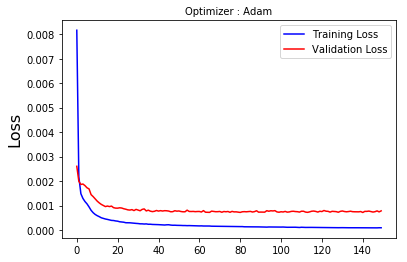

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [8]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

imgs_test.shape  # (1783, 96, 96)

(1783, 96, 96)

In [9]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

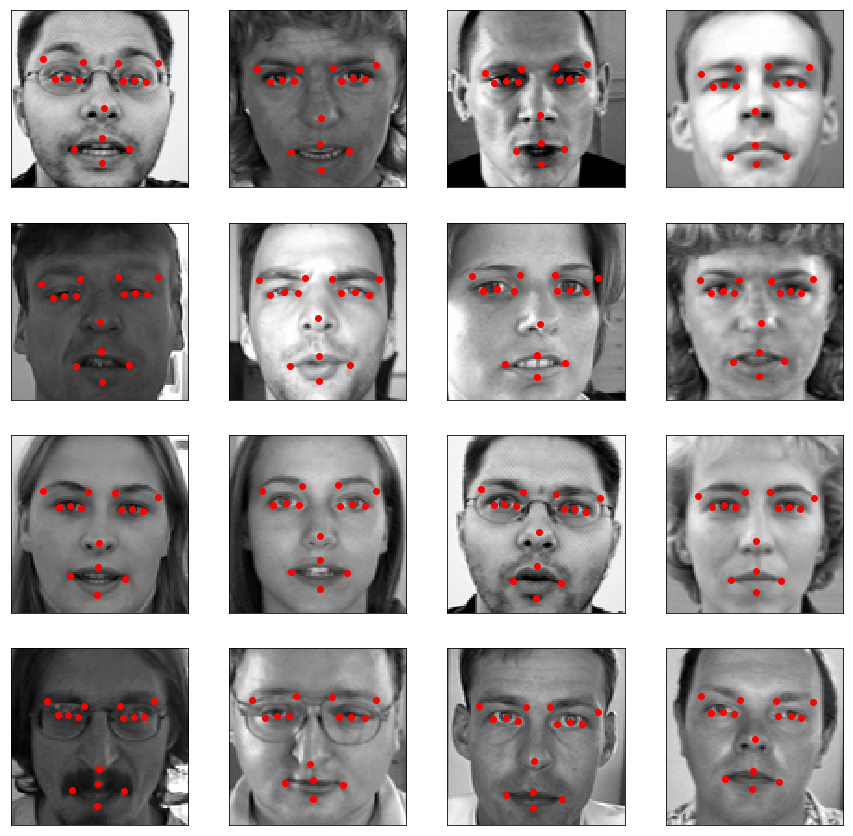

In [21]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    #plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))
    plot_keypoints(imgs_test[i], points_test[i])

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [10]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# Your code

In [12]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('augment_best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [13]:
from keras.preprocessing.image import ImageDataGenerator # Data Augmentation(資料增強)
img_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rotation_range=20, 
                             width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                             horizontal_flip=True, vertical_flip=True, dtype=np.float32)

val_split=0.2
num_val = int(len(imgs_train)*val_split)  # 測試資料: 20 % (428 筆資料)
num_train = len(imgs_train) - num_val     # 訓練資料: 80 % (1712 筆資料)
batch = 64
hist_model_augment = model_with_augment.fit_generator(img_gen.flow(imgs_train.reshape(-1, 96, 96, 1)[:num_train], 
                                                                   points_train[:num_train], batch_size=64), 
                                 steps_per_epoch = num_train // batch, epochs=150, 
                                 validation_data =(imgs_train.reshape(-1, 96, 96, 1)[num_train:], points_train[num_train:]),
                                 callbacks = [checkpoint, hist])





Epoch 1/150




C:\Users\andyhu\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\andyhu\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '





26/26 [==============================] - 11s 411ms/step - loss: 0.0066 - val_loss: 0.0023

Epoch 00001: val_loss improved from inf to 0.00227, saving model to augment_best_weights.h5
Epoch 2/150
26/26 [==============================] - 2s 78ms/step - loss: 0.0019 - val_loss: 0.0020

Epoch 00002: val_loss improved from 0.00227 to 0.00196, saving model to augment_best_weights.h5
Epoch 3/150
26/26 [==============================] - 2s 60ms/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00196 to 0.00187, saving model to augment_best_weights.h5
Epoch 4/150
26/26 [==============================] - 2s 60ms/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00187
Epoch 5/150
26/26 [==============================] - 2s 60ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00187
Epoch 6/150
26/26 [==============================] - 2s 60ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00006: va

26/26 [==============================] - 2s 61ms/step - loss: 8.2120e-04 - val_loss: 0.0018

Epoch 00047: val_loss improved from 0.00176 to 0.00175, saving model to augment_best_weights.h5
Epoch 48/150
26/26 [==============================] - 2s 62ms/step - loss: 7.6434e-04 - val_loss: 0.0018

Epoch 00048: val_loss did not improve from 0.00175
Epoch 49/150
26/26 [==============================] - 2s 62ms/step - loss: 7.8607e-04 - val_loss: 0.0018

Epoch 00049: val_loss did not improve from 0.00175
Epoch 50/150
26/26 [==============================] - 2s 61ms/step - loss: 7.8449e-04 - val_loss: 0.0018

Epoch 00050: val_loss did not improve from 0.00175
Epoch 51/150
26/26 [==============================] - 2s 63ms/step - loss: 7.9504e-04 - val_loss: 0.0018

Epoch 00051: val_loss did not improve from 0.00175
Epoch 52/150
26/26 [==============================] - 2s 61ms/step - loss: 7.4304e-04 - val_loss: 0.0018

Epoch 00052: val_loss did not improve from 0.00175
Epoch 53/150
26/26 [======

26/26 [==============================] - 2s 60ms/step - loss: 6.2591e-04 - val_loss: 0.0017

Epoch 00097: val_loss did not improve from 0.00166
Epoch 98/150
26/26 [==============================] - 2s 59ms/step - loss: 6.3808e-04 - val_loss: 0.0017

Epoch 00098: val_loss did not improve from 0.00166
Epoch 99/150
26/26 [==============================] - 2s 59ms/step - loss: 6.2150e-04 - val_loss: 0.0017

Epoch 00099: val_loss did not improve from 0.00166
Epoch 100/150
26/26 [==============================] - 2s 60ms/step - loss: 6.3037e-04 - val_loss: 0.0017

Epoch 00100: val_loss did not improve from 0.00166
Epoch 101/150
26/26 [==============================] - 2s 59ms/step - loss: 6.0136e-04 - val_loss: 0.0017

Epoch 00101: val_loss did not improve from 0.00166
Epoch 102/150
26/26 [==============================] - 2s 59ms/step - loss: 6.0887e-04 - val_loss: 0.0017

Epoch 00102: val_loss did not improve from 0.00166
Epoch 103/150
26/26 [==============================] - 2s 59ms/step 


Epoch 00148: val_loss did not improve from 0.00166
Epoch 149/150
26/26 [==============================] - 2s 60ms/step - loss: 5.1434e-04 - val_loss: 0.0018

Epoch 00149: val_loss did not improve from 0.00166
Epoch 150/150
26/26 [==============================] - 2s 60ms/step - loss: 5.2699e-04 - val_loss: 0.0017

Epoch 00150: val_loss did not improve from 0.00166


In [14]:
# save the model weights
model_with_augment.save_weights('augment_weights.h5')
# save the model
model_with_augment.save('augment_model.h5')

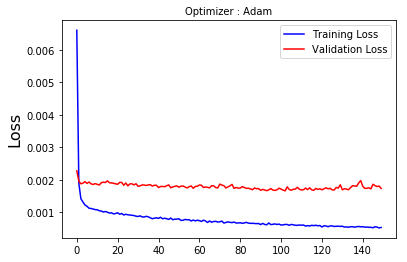

In [15]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_augment.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_augment.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip